<a href="https://colab.research.google.com/github/dansarmiento/machine_learning_notebooks/blob/main/mental_health_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Understanding the task**

The aim of this competition is to predict the Severity Impairment Index (sii), which measures the level of problematic internet use among children and adolescents, based on physical activity data and other features.

sii is derived from PCIAT-PCIAT_Total, the sum of scores from the Parent-Child Internet Addiction Test (PCIAT: 20 questions, scored 0-5).

Target Variable (sii) is defined as:

0: None (PCIAT-PCIAT_Total from 0 to 30)

1: Mild (PCIAT-PCIAT_Total from 31 to 49)

2: Moderate (PCIAT-PCIAT_Total from 50 to 79)

3: Severe (PCIAT-PCIAT_Total 80 and more)

This makes sii an ordinal categorical variable with four levels, where the order of categories is meaningful.

Type of Machine Learning Problem we can use with sii as a target:

Ordinal classification (ordinal logistic regression, models with custom ordinal loss functions)

Multiclass classification (treat sii as a nominal categorical variable without considering the order)

Regression (ignore the discrete nature of categories and treat sii as a continuous variable, then round prediction)

Custom (e.g. loss functions that penalize errors based on the distance between categories)

We can also use PCIAT-PCIAT_Total as a continuous target variable, and implement regression on PCIAT-PCIAT_Total and then map predictions to sii categories.

Finally, another strategy involves predicting responses to each question of the Parent-Child Internet Addiction Test: i.e. pedict individual question scores as separate targets, sum the predicted scores to get the PCIAT-PCIAT_Total and map predictions to the corresponding sii category.

But first, let's make some exploratory data analysis.

In [3]:
!pip install category_encoders
!pip install xgboost
!pip install catboost
!pip install plotly
!pip install squarify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.6 MB/s eta 0:00:00


In [4]:
# Core Libraries
import pandas as pd
import numpy as np
from scipy import stats
import random
import warnings

# Visualization Libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import squarify
%matplotlib inline

# Machine Learning Libraries
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, HistGradientBoostingClassifier

# Set random seed
rs = 42

# Ignore warnings
warnings.filterwarnings("ignore")

# Set color palette for Seaborn
colors= ['#1c76b6', '#a7dae9', '#eb6a20', '#f59d3d', '#677fa0', '#d6e4ed', '#f7e9e5']
sns.set_palette(colors)

In [6]:
import re

url = 'https://docs.google.com/spreadsheets/d/1YKcR6X_aYEj5s_YABtZiUx9g_-zFJzdIBt6mbv8Uof0/edit?usp=sharing'

# Extract sheet_id using regex
match = re.search(r'/d/([a-zA-Z0-9-_]+)', url)
sheet_id = match.group(1) if match else None

# Sheet names to load
sheet_names = ['train', 'test']

# Dynamically create DataFrames for each sheet
for name in sheet_names:
    gsheet_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={name}"
    df = pd.read_csv(gsheet_url)
    df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('/', '_')
    globals()[name] = df  # Assigns DataFrame to variable named after sheet (e.g., train, test)

In [7]:
train.head()

,id,name,gender,age,city,working_professional_or_student,profession,academic_pressure,work_pressure,cgpa,study_satisfaction,job_satisfaction,sleep_duration,dietary_habits,degree,have_you_ever_had_suicidal_thoughts_?,work_study_hours,financial_stress,family_history_of_mental_illness,depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [8]:
test.head()

,id,name,gender,age,city,working_professional_or_student,profession,academic_pressure,work_pressure,cgpa,study_satisfaction,job_satisfaction,sleep_duration,dietary_habits,degree,have_you_ever_had_suicidal_thoughts_?,work_study_hours,financial_stress,family_history_of_mental_illness
0,140700,Shivam,Male,53.0,Visakhapatnam,Working Professional,Judge,NaN,2.0,NaN,NaN,5.0,Less than 5 hours,Moderate,LLB,No,9.0,3.0,Yes
1,140701,Sanya,Female,58.0,Kolkata,Working Professional,Educational Consultant,NaN,2.0,NaN,NaN,4.0,Less than 5 hours,Moderate,B.Ed,No,6.0,4.0,No
2,140702,Yash,Male,53.0,Jaipur,Working Professional,Teacher,NaN,4.0,NaN,NaN,1.0,7-8 hours,Moderate,B.Arch,Yes,12.0,4.0,No
3,140703,Nalini,Female,23.0,Rajkot,Student,NaN,5.0,NaN,6.84,1.0,NaN,More than 8 hours,Moderate,BSc,Yes,10.0,4.0,No
4,140704,Shaurya,Male,47.0,Kalyan,Working Professional,Teacher,NaN,5.0,NaN,NaN,5.0,7-8 hours,Moderate,BCA,Yes,3.0,4.0,No


In [9]:
# check to see the size of both dataframes
# these are labeled a bit weirdly, the test dataset is actually not a labeled dataset
train.shape, test.shape

((140700, 20), (93800, 19))

In [11]:
# lots of nulls
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   name                                   140700 non-null  object 
 2   gender                                 140700 non-null  object 
 3   age                                    140700 non-null  float64
 4   city                                   140700 non-null  object 
 5   working_professional_or_student        140700 non-null  object 
 6   profession                             104070 non-null  object 
 7   academic_pressure                      27897 non-null   float64
 8   work_pressure                          112782 non-null  float64
 9   cgpa                                   27898 non-null   float64
 10  study_satisfaction                     27897 non-null   

In [13]:
# Save 'id' column for submission
test_ids = test['id']

# Drop 'id' column in both datasets
df_train = train.drop(['id'], axis=1)
df_test = test.drop(['id'], axis=1)

# Define the target column
target_column = 'depression'

# Select categorical and numerical columns (initial)
categorical_columns = df_train.select_dtypes(include=['object']).columns
numerical_columns = df_train.select_dtypes(exclude=['object']).columns.drop(target_column)

# Print out column information
print("Target Column:", target_column)
print("\nCategorical Columns:", categorical_columns.tolist())
print("\nNumerical Columns:", numerical_columns.tolist())

Target Column: depression

Categorical Columns: ['name', 'gender', 'city', 'working_professional_or_student', 'profession', 'sleep_duration', 'dietary_habits', 'degree', 'have_you_ever_had_suicidal_thoughts_?', 'family_history_of_mental_illness']

Numerical Columns: ['age', 'academic_pressure', 'work_pressure', 'cgpa', 'study_satisfaction', 'job_satisfaction', 'work_study_hours', 'financial_stress']


In [14]:
for column in categorical_columns:
    num_unique = df_train[column].nunique()
    print(f"'{column}' has {num_unique} unique categories.")

'name' has 422 unique categories.
'gender' has 2 unique categories.
'city' has 98 unique categories.
'working_professional_or_student' has 2 unique categories.
'profession' has 64 unique categories.
'sleep_duration' has 36 unique categories.
'dietary_habits' has 23 unique categories.
'degree' has 115 unique categories.
'have_you_ever_had_suicidal_thoughts_?' has 2 unique categories.
'family_history_of_mental_illness' has 2 unique categories.


In [15]:
# Print top 10 unique value counts for each categorical column
for column in categorical_columns:
    print(f"\nTop value counts in '{column}':\n{df_train[column].value_counts().head(10)}")


Top value counts in 'name':
name
Rohan          3178
Aarav          2336
Rupak          2176
Aaradhya       2045
Anvi           2035
Raghavendra    1877
Vani           1657
Tushar         1596
Ritvik         1589
Shiv           1568
Name: count, dtype: int64

Top value counts in 'gender':
gender
Male      77464
Female    63236
Name: count, dtype: int64

Top value counts in 'city':
city
Kalyan           6591
Patna            5924
Vasai-Virar      5765
Kolkata          5689
Ahmedabad        5613
Meerut           5528
Ludhiana         5226
Pune             5210
Rajkot           5207
Visakhapatnam    5176
Name: count, dtype: int64

Top value counts in 'working_professional_or_student':
working_professional_or_student
Working Professional    112799
Student                  27901
Name: count, dtype: int64

Top value counts in 'profession':
profession
Teacher             24906
Content Writer       7814
Architect            4370
Consultant           4229
HR Manager           4022
Pharmacist  

In [16]:
print("The skewness of columns:")
print(df_train[numerical_columns].skew())

The skewness of columns:
age                  -0.217977
academic_pressure    -0.133977
work_pressure         0.018515
cgpa                 -0.073636
study_satisfaction    0.011764
job_satisfaction      0.054361
work_study_hours     -0.128169
financial_stress      0.035603
dtype: float64


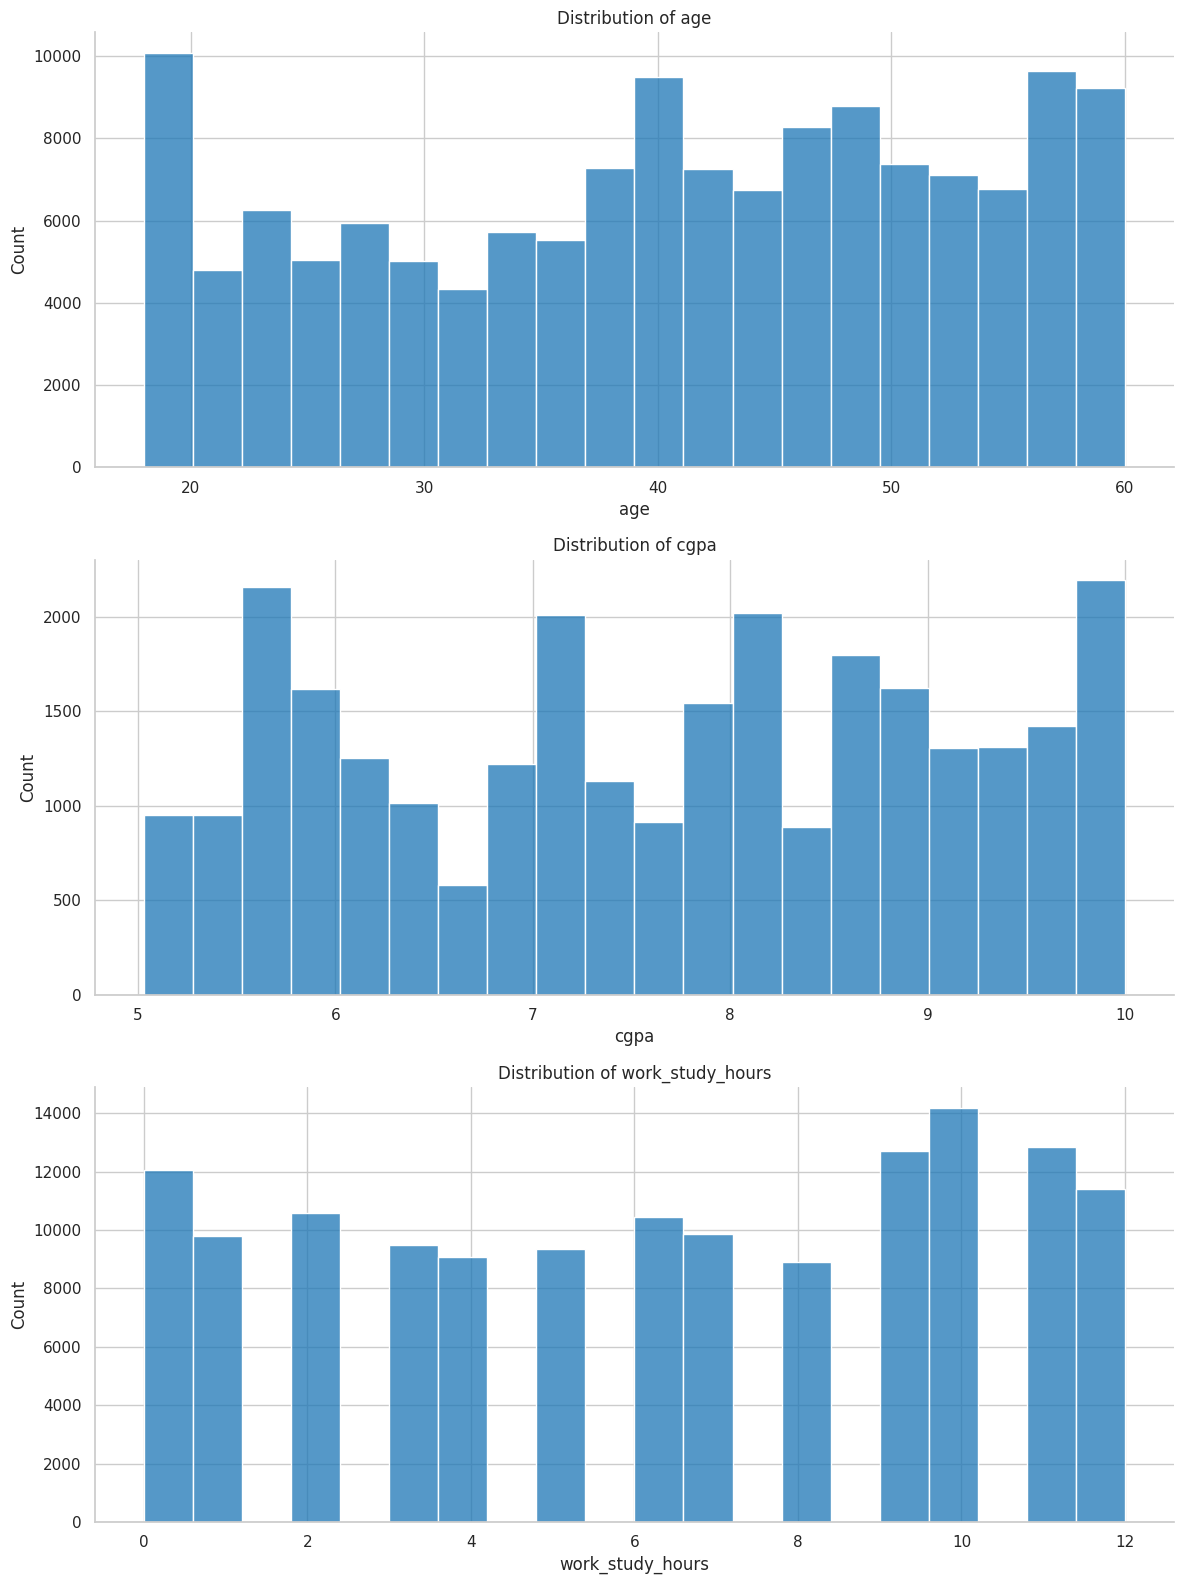

In [18]:

numerical_columns_to_plot = ['age',  'cgpa', 'work_study_hours']

plt.figure(figsize=(12, 16))

for i, column in enumerate(numerical_columns_to_plot):
    plt.subplot(3, 1, i+1)
    sns.histplot(data=df_train, x=column, kde=False, bins=20, color=colors[0])
    plt.title(f'Distribution of {column}')
    sns.despine()

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

In [21]:
categorical_columns

Index(['name', 'gender', 'city', 'working_professional_or_student',
       'profession', 'sleep_duration', 'dietary_habits', 'degree',
       'have_you_ever_had_suicidal_thoughts_?',
       'family_history_of_mental_illness'],
      dtype='object')

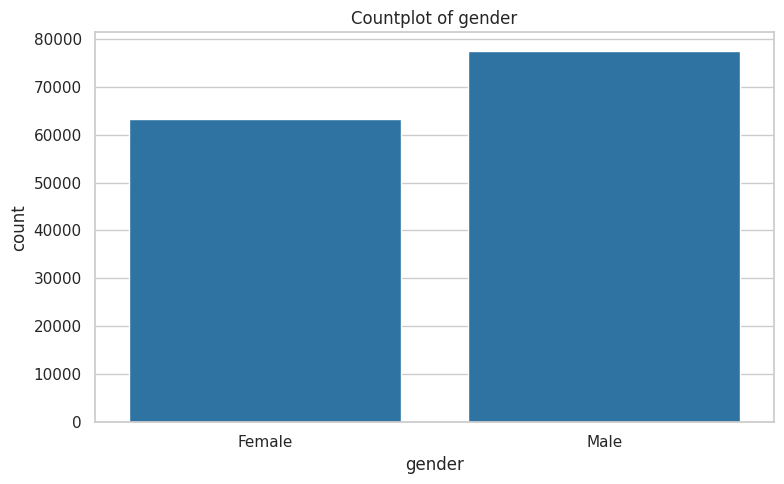

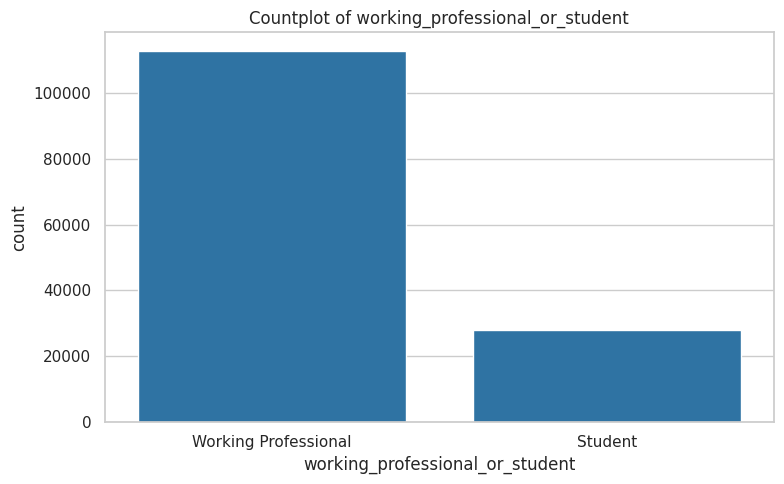

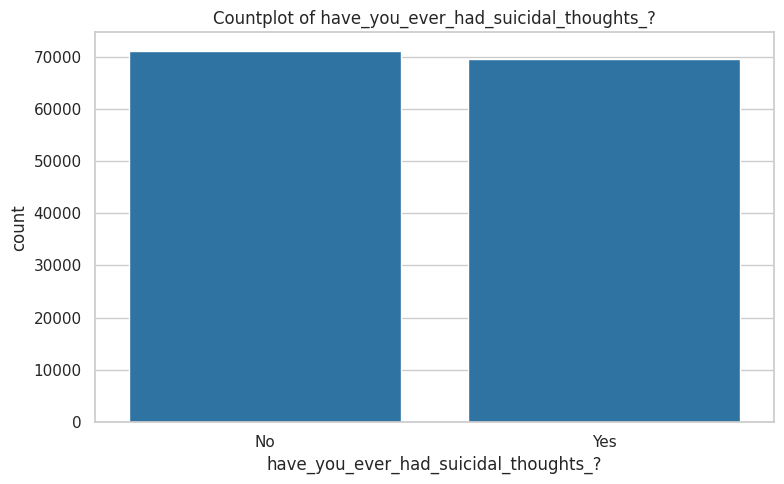

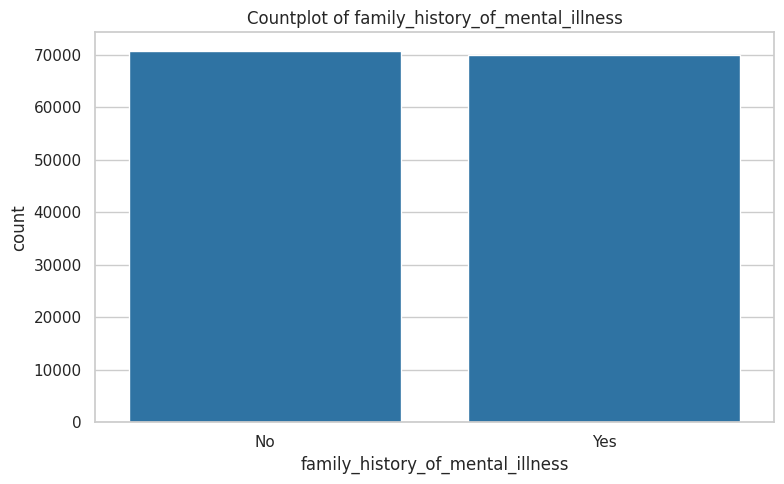

In [22]:
categorical_columns_to_plot = ['gender', 'working_professional_or_student', 'have_you_ever_had_suicidal_thoughts_?', 'family_history_of_mental_illness']
# Plot countplots for each categorical column
for column in categorical_columns_to_plot:

    plt.figure(figsize=(8, 5))
    sns.countplot(data=df_train, x=column)
    plt.title(f'Countplot of {column}')

    plt.tight_layout()
    plt.show()

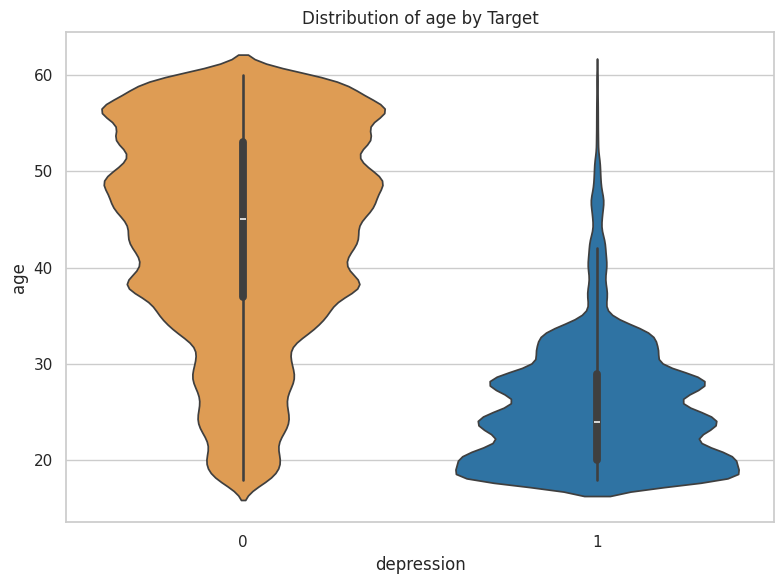

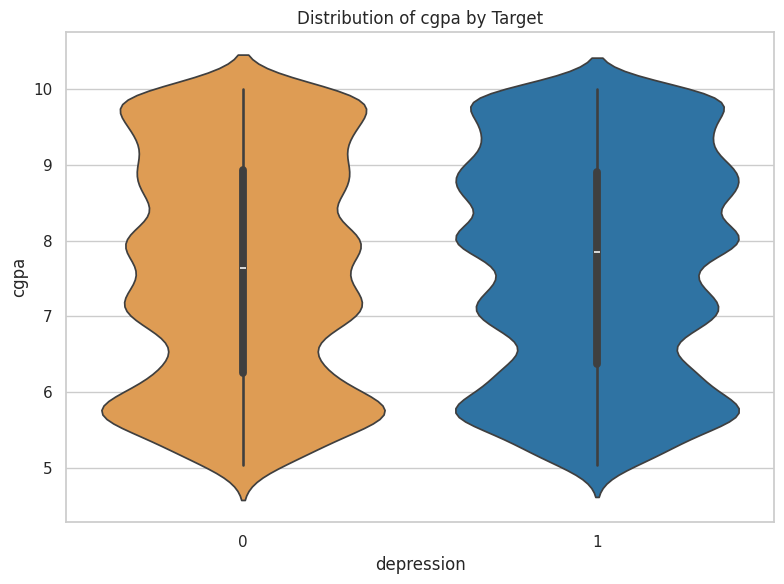

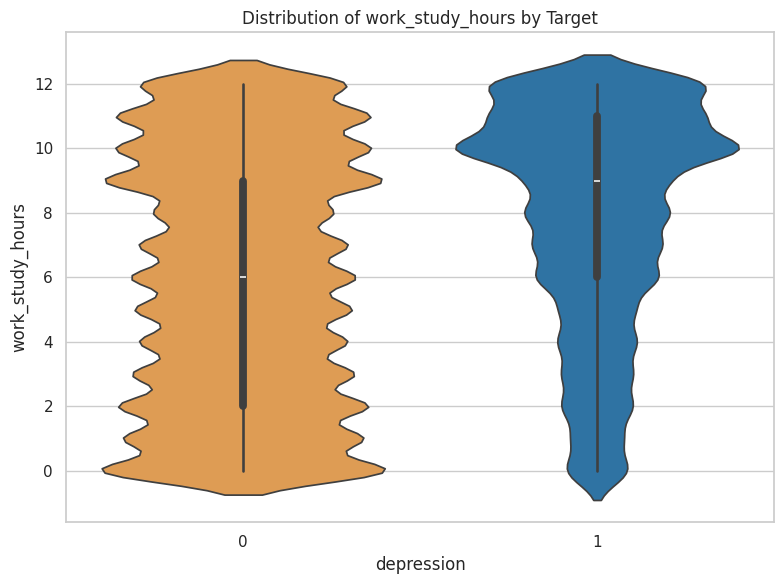

In [23]:
bi_palette = [colors[3], colors[0]]

for column in numerical_columns_to_plot:
    plt.figure(figsize=(8, 6))
    sns.violinplot(data=df_train, x=target_column, y=column, palette=bi_palette)
    plt.title(f'Distribution of {column} by Target')

    plt.tight_layout()
    plt.show()

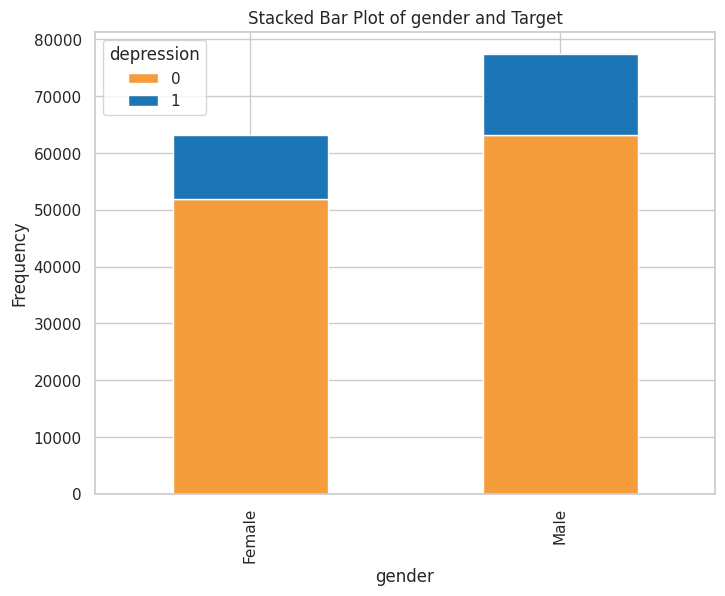

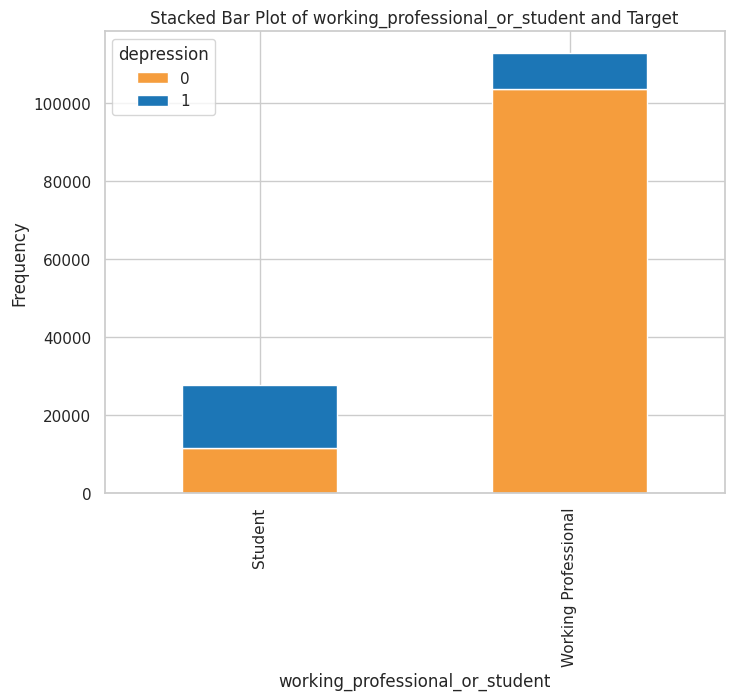

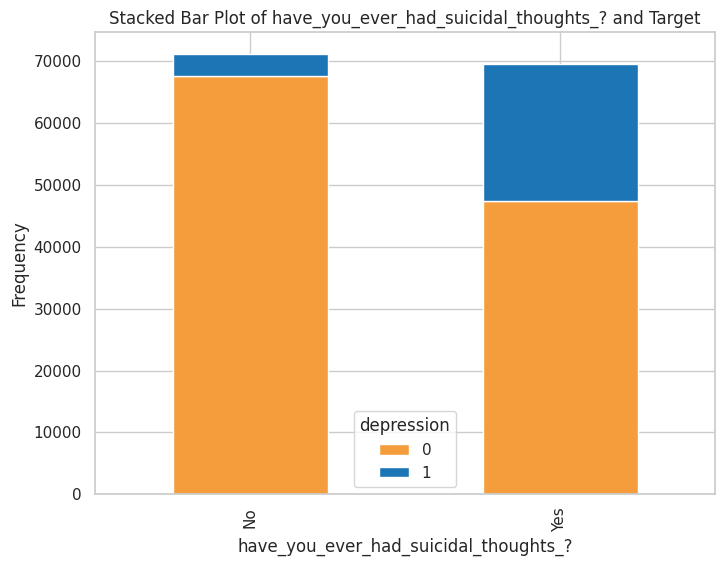

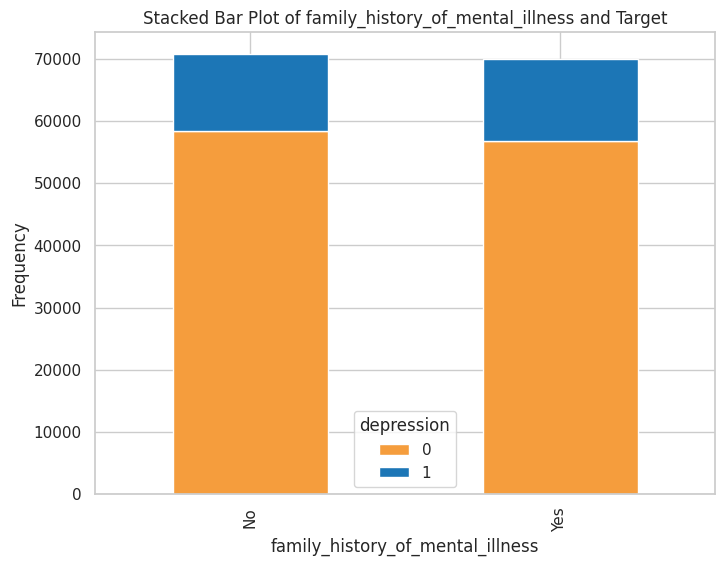

In [24]:
cmap = LinearSegmentedColormap.from_list("custom_cmap", bi_palette)

# Loop through each categorical column in your list
for column in categorical_columns_to_plot:
    # Stacked Bar Plot
    pd.crosstab(df_train[column], df_train[target_column]).plot(kind='bar', stacked=True, colormap=cmap, figsize=(8, 6))
    plt.title(f"Stacked Bar Plot of {column} and Target")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

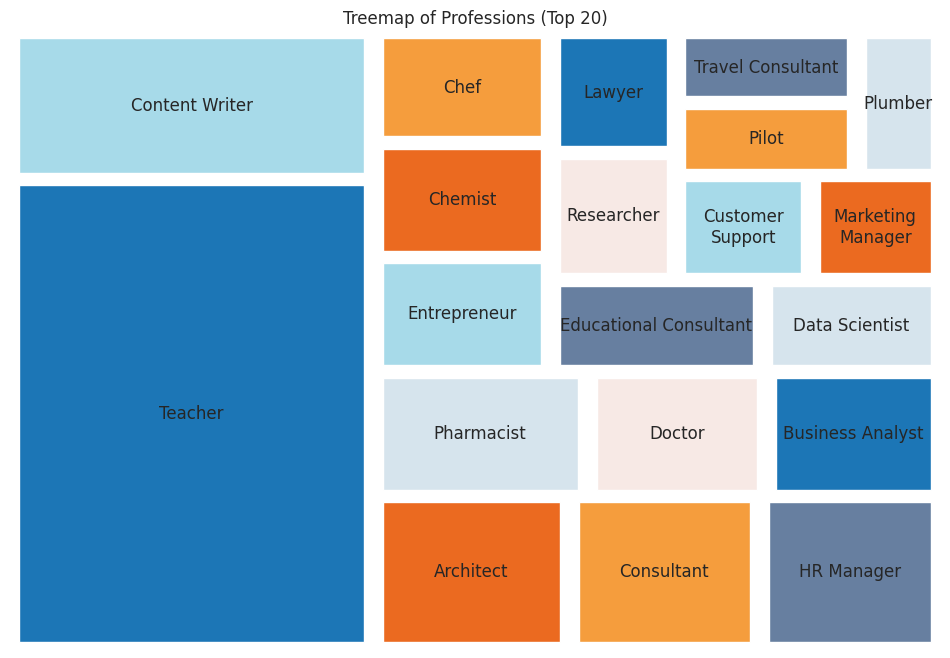

In [26]:
# Calculate frequencies
value_counts = df_train['profession'].value_counts()
sizes = value_counts.values[:20]  # Show only the top 20 for readability

# Modify specific labels to show on two lines and limit to top 20 labels
labels = [
    "Customer\nSupport" if label == "Customer Support" else
    "Marketing\nManager" if label == "Marketing Manager" else
    label
    for label in value_counts.index[:20]
]

plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=labels, color=colors, pad=True)
plt.title(f"Treemap of Professions (Top 20)")
plt.axis("off")
plt.show()

In [37]:
labels.index

<function list.index(value, start=0, stop=9223372036854775807, /)>

In [39]:
# Create a DataFrame for the top 20 professions and their relationship with depression
top_n_professions = 20
profession_counts = df_train['profession'].value_counts().nlargest(top_n_professions)
filtered_data = df_train[df_train['profession'].isin(profession_counts.index)]

# Create a summary DataFrame
sankey_data = filtered_data.groupby(['profession', 'depression']).size().reset_index(name='Count')

# Define the source and target for the Sankey chart
labels = list(sankey_data['profession'].unique()) + ['No Depression', 'Depression']
source_indices = []
target_indices = []

for _, row in sankey_data.iterrows():
    profession_index = labels.index(row['profession'])
    depression_index = labels.index('Depression' if row['depression'] == 1 else 'No Depression')
    source_indices.append(profession_index)
    target_indices.append(depression_index)

# Create a Sankey chart
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color='blue'
    ),
    link=dict(
        source=source_indices,  # Indices correspond to labels, e.g., A=0, B=1, C=2...
        target=target_indices,
        value=sankey_data['Count']
    )
)])

fig.update_layout(
    title_text="Sankey Diagram of Profession and Depression",
    font_size=10,
    width=700,
    height=600)

fig.show()

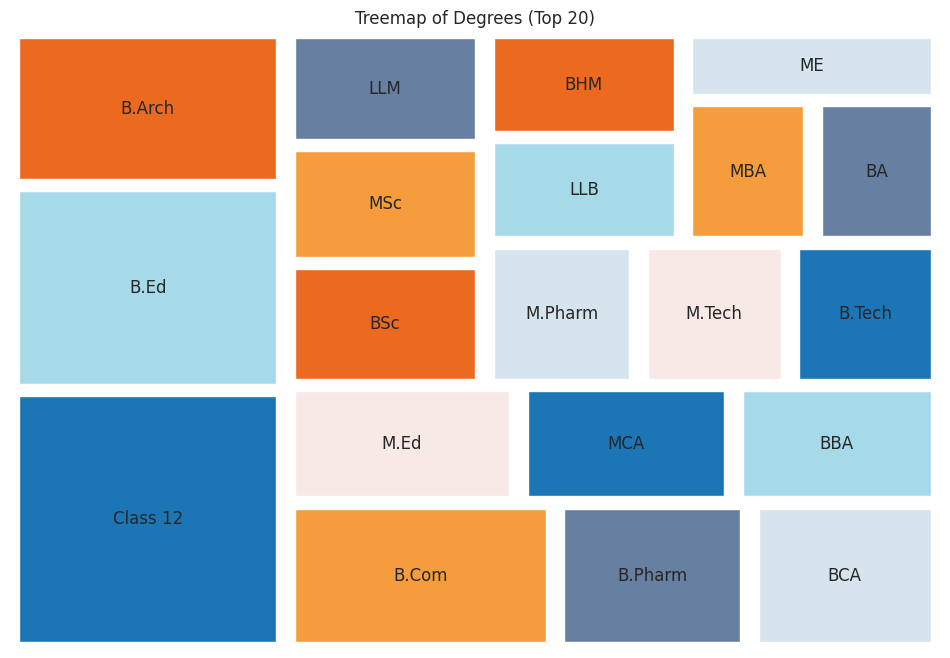

In [41]:
# Calculate frequencies
value_counts = df_train['degree'].value_counts()
sizes = value_counts.values[:20]  # Show only the top 20 for readability

plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=value_counts.index[:20], color=colors, pad=True)
plt.title(f"Treemap of Degrees (Top 20)")
plt.axis("off")
plt.show()

In [44]:
# Get the top 10 most common professions
top_professions = df_train['degree'].value_counts().nlargest(10).index

# Filter the DataFrame for the top 10 professions
filtered_df = df_train[df_train['degree'].isin(top_professions)]

# Create a new DataFrame for aggregation
agg_data = filtered_df.groupby(['degree', 'depression']).size().reset_index(name='Count')

# Create a sunburst chart
fig = px.sunburst(agg_data,
                  path=['degree', 'depression'],
                  values='Count',
                  title='Sunburst Chart of Top 10 Degrees and Depression',
                  color='Count',
                  color_continuous_scale=px.colors.sequential.Oranges[:])

# Show the figure
fig.show()

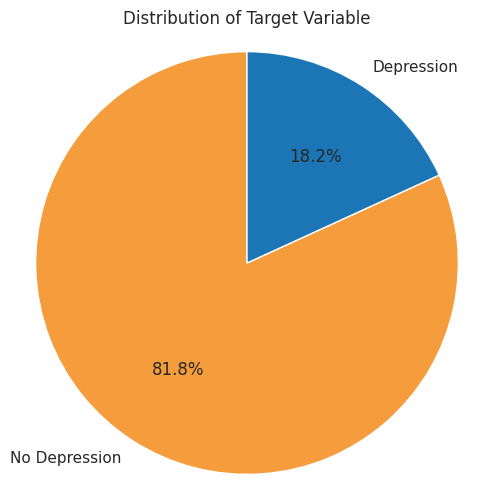

In [45]:
# Calculate counts for the pie chart and add labels
class_counts = df_train[target_column].value_counts().sort_index()
labels = ["No Depression", "Depression"]
plt.figure(figsize=(6, 6))
plt.pie(class_counts, colors=bi_palette, labels=labels,
        autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Target Variable')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [46]:
# Calculate the correlation matrix
correlation_matrix = df_train.corr(numeric_only=True)

# Create an interactive heatmap with orange and blue colors
fig = px.imshow(correlation_matrix,
                text_auto=True,  # Display correlation values
                color_continuous_scale='RdYlBu',  # Color scale with shades of red, yellow, and blue
                title='Heatmap of Correlation Matrix',
                aspect='auto')

# Show the plot
fig.show()

In [47]:
# Drop rows with NaN values in 'Age', 'Work Pressure', and 'Depression' columns
df_train_copy = df_train.dropna(subset=['age', 'work_pressure', 'depression'])

# Create bins for Age and Work Pressure
df_train_copy['Age_bin'] = pd.cut(df_train_copy['age'], bins=10).astype(str)           # Convert the bins to strings (to avoid serialization issues)
df_train_copy['WorkPressure_bin'] = pd.cut(df_train_copy['work_pressure'], bins=10).astype(str)

# Create pivot table
heatmap_data = df_train_copy.pivot_table(index='Age_bin', columns='WorkPressure_bin', values='depression', aggfunc='mean')

# Create an interactive heatmap with orange and blue colors
fig = px.imshow(heatmap_data.values,  # Use only the numerical matrix
                labels=dict(x="Work Pressure Bin", y="Age Bin", color="depression"),
                text_auto=True,  # Display correlation values
                color_continuous_scale='RdYlBu',  # Color scale with shades of red, yellow, and blue
                title='Heatmap of Depression by Age and Work Pressure',
                aspect='auto')

# Set the y-axis and x-axis tick labels to the actual bin ranges
fig.update_layout(
    yaxis=dict(
        tickmode='array',
        tickvals=list(range(len(heatmap_data.index))),  # Set tick positions
        ticktext=heatmap_data.index.astype(str).tolist()  # Convert intervals to strings for labels
    ),
    xaxis=dict(
        tickmode='array',
        tickvals=list(range(len(heatmap_data.columns))),  # Set tick positions
        ticktext=heatmap_data.columns.astype(str).tolist()  # Convert intervals to strings for labels
    )
)

# Show the plot
fig.show()

In [48]:
# Feature Engineering
# Create an interaction term between Age and Work Pressure
df_train['Age_WorkPressure'] = df_train['age'] * df_train['work_pressure']
df_test['Age_WorkPressure'] = df_test['age'] * df_test['work_pressure']

# Target encoding for categorical features
encoder = TargetEncoder(cols=['city', 'profession'])
df_train[['City_encoded', 'Profession_encoded']] = encoder.fit_transform(df_train[['city', 'profession']], df_train["depression"])
df_test[['City_encoded', 'Profession_encoded']] = encoder.transform(df_test[['city', 'profession']])

In [49]:
# Define features and target
X_train = df_train.drop('depression', axis=1)
y_train = df_train['depression']

# Redefine columns for preprocessing after feature engineering
numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()

# Define preprocessing pipelines
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('convert_to_float32', FunctionTransformer(lambda x: x.astype(np.float32)))
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder(dtype=np.int32, handle_unknown='use_encoded_value', unknown_value=-1))
])

# Combine the numerical and categorical pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_columns),
        ('cat', categorical_pipeline, categorical_columns)
    ]
)

# Apply the transformations to the training and test sets
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(df_test)

In [50]:
# Apply Isolation Forest for outlier detection on the training data
isolation_forest = IsolationForest(contamination=0.04, random_state=rs)
outlier_labels = isolation_forest.fit_predict(X_train_preprocessed)

# Filter out outliers from both X_train_preprocessed and y_train
non_outliers_mask = outlier_labels != -1
X_train_preprocessed = X_train_preprocessed[non_outliers_mask]
y_train = y_train[non_outliers_mask]

In [54]:
# Define parameters
xgb_params = {
     'learning_rate': 0.298913248058474,
     'max_depth': 9,
     'min_child_weight': 3,
     'n_estimators': 673,
     'subsample': 0.5933970249700855,
     'gamma': 2.597137534750985,
     'reg_lambda': 0.11328048420927406,
     'colsample_bytree': 0.1381203919800721
}

catboost_params = {
    'iterations': 145,
    'depth': 7,
    'learning_rate': 0.29930179265937246,
    'l2_leaf_reg': 1.242352421942431,
    'random_strength': 8.325681754379957,
    'bagging_temperature': 0.7869848919618048,
    'border_count': 139
}

hgb_params = {
    'learning_rate': 0.16299202834206894,
    'max_iter': 250,
    'max_depth': 4,
    'l2_regularization': 7.1826466833939895,
    'early_stopping': True
}

# Initialize models with pre-tuned and trial-specific parameters
xgb_model = XGBClassifier(**xgb_params, use_label_encoder=False, random_state=rs)
catboost_model = CatBoostClassifier(**catboost_params, task_type="CPU", random_state=rs, verbose=0)
hgb_model = HistGradientBoostingClassifier(**hgb_params, random_state=rs)

# Define stacking ensemble with the LightGBM model tuned in this trial
stacking_ensemble = StackingClassifier(
    estimators=[
        ('catboost', catboost_model),
        ('xgb', xgb_model),
        ('hgb', hgb_model)
    ],
    final_estimator=LogisticRegression(),
    passthrough=False
)

In [55]:
# Define a scoring metric
scoring = make_scorer(accuracy_score)

# Perform cross-validation
cv_scores = cross_val_score(stacking_ensemble, X_train_preprocessed, y_train, cv=5, scoring=scoring)

# Print cross-validation results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation of CV Accuracy: {cv_scores.std():.4f}")

Cross-Validation Scores: [0.94199519 0.94343883 0.94277042 0.94388095 0.94528763]
Mean CV Accuracy: 0.9435
Standard Deviation of CV Accuracy: 0.0011


In [56]:
# Fit the model
stacking_ensemble.fit(X_train_preprocessed, y_train)

# Make predictions
test_preds = stacking_ensemble.predict(X_test_preprocessed)

In [57]:
# Create a DataFrame to hold the submission results
output = pd.DataFrame({'id': test_ids,
                       'class': test_preds})

# Save the output DataFrame to a CSV file
output.to_csv('submission.csv', index=False)

output.head()

,id,class
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0
